In [3]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
data = pd.read_csv('dataset\AirPassengers.csv', usecols=[1], engine='python')
data = data.astype('float32')

In [37]:
data

,#Passengers
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0
...,...
139,606.0
140,508.0
141,461.0
142,390.0


In [6]:
test_data_size = 12

train_data = data[:-test_data_size]
test_data = data[-test_data_size:]

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data) ## output is a numpy array
train_data_normalized.shape # shape is (132,1)

(132, 1)

In [13]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape ## size is ([132])

torch.Size([132])

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
## len(train_inout_seq) is 120 = train_data_normalized.shape[0] - train_window

In [17]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [28]:
#input_size = number of features
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm1 = nn.LSTM(input_size, hidden_layer_size)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size)

        ## nn.Linear is the same as Dense in keras
        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out1, self.hidden_cell1 = self.lstm1(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out2, self.hidden_cell2 = self.lstm2(lstm_out1, self.hidden_cell1)
        predictions = self.linear(lstm_out2.view(len(input_seq), -1))
        return predictions[-1]

In [68]:
#input_size = number of features
class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.bilstm1 = nn.LSTM(input_size, hidden_layer_size, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_layer_size*2, hidden_layer_size, bidirectional=True)

        #self.relu = nn.ReLU()


        ## nn.Linear is the same as Dense in keras
        self.linear = nn.Linear(hidden_layer_size*2, output_size)

        self.hidden_cell = (torch.zeros(2,1,self.hidden_layer_size),
                            torch.zeros(2,1,self.hidden_layer_size))

    def forward(self, input_seq):
        bilstm_out1, self.hidden_cell1 = self.bilstm1(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        bilstm_out2, self.hidden_cell2 = self.bilstm2(bilstm_out1, self.hidden_cell1)
        #relu_out = self.relu(bilstm_out2)
        predictions = self.linear(bilstm_out2.view(len(input_seq), -1))
        return predictions[-1]

In [94]:
#input_size = number of features
##this one is not working
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, batch_size = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.batch_size = batch_size

        self.gru1 = nn.GRU(input_size, hidden_layer_size)
        self.gru2 = nn.GRU(hidden_layer_size, hidden_layer_size)

        #self.relu = nn.ReLU()


        ## nn.Linear is the same as Dense in keras
        self.linear = nn.Linear(hidden_layer_size, output_size)

        #self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
        #                    torch.zeros(1,1,self.hidden_layer_size))
        self.hidden_cell = torch.zeros(1, self.batch_size, self.hidden_layer_size)


    def forward(self, input_seq):
        #h0 = torch.zeros(2, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        gru_out1, _ = self.gru1(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        gru_out2, _ = self.gru2(gru_out1)
        predictions = self.linear(gru_out2.view(len(input_seq), -1))
        return predictions[-1]

In [95]:
model = GRU()
loss_function = nn.MSELoss() #mean square error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [96]:
model

GRU(
  (gru1): GRU(1, 100)
  (gru2): GRU(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [97]:
epochs = 11

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%5 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

AttributeError: 'tuple' object has no attribute 'dim'

In [72]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527477741241455, 0.046153903007507324, 0.3274726867675781, 0.28351664543151855, 0.3890111446380615, 0.6175825595855713, 0.951648473739624, 1.000000238418579, 0.5780220031738281, 0.3318682909011841, 0.13406598567962646, 0.32307708263397217]


In [73]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [74]:
test_inputs[fut_pred:]

[0.5569818615913391,
 0.6872432827949524,
 1.077452540397644,
 1.2820464372634888,
 1.7284669876098633,
 2.717080593109131,
 3.420949935913086,
 3.4385998249053955,
 3.2513906955718994,
 3.1509974002838135,
 3.142617702484131,
 3.250526189804077]

In [75]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[ 458.21334608]
 [ 487.84781803]
 [ 576.62042002]
 [ 623.16552941]
 [ 724.7261999 ]
 [ 949.63578473]
 [1109.7660528 ]
 [1113.78140236]
 [1071.19132741]
 [1048.35185379]
 [1046.44547263]
 [1070.99465236]]


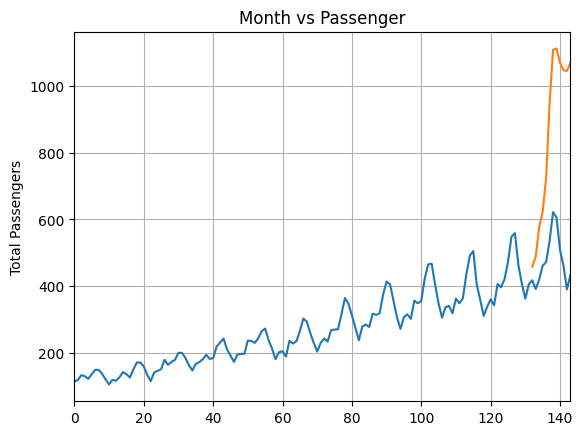

In [76]:
x = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['#Passengers'])
plt.plot(x,actual_predictions)
plt.show()